In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, relu, Chain, ADAM, Descent, params, throttle, Dropout, @epochs, testmode!

using Base.Iterators: repeated

using Plots, DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter, LaTeXStrings
pyplot() # using the pyplot backend

using BSON: @save, @load
using NNlib

# DATA IMPORT

In [2]:
X_columns = h5read("./data/DataSet.hdf5", "X_columns")

X_entropy_train = h5read("./data/DataSet.hdf5", "X_entropy_train")
X_entropy_train_sc = h5read("./data/DataSet.hdf5", "X_entropy_train_sc")

X_entropy_valid = h5read("./data/DataSet.hdf5", "X_entropy_valid")
X_entropy_valid_sc = h5read("./data/DataSet.hdf5", "X_entropy_valid_sc")

X_entropy_test = h5read("./data/DataSet.hdf5", "X_entropy_test")
X_entropy_test_sc = h5read("./data/DataSet.hdf5", "X_entropy_test_sc")

X_entropy_sc_tv = [X_entropy_train_sc X_entropy_valid_sc]

X_tv = h5read("./data/DataSet.hdf5", "X_tv")
X_tv_sc = h5read("./data/DataSet.hdf5", "X_tv_sc")
y_tv = h5read("./data/DataSet.hdf5", "y_tv")

X_train = h5read("./data/DataSet.hdf5", "X_train")
X_train_sc = h5read("./data/DataSet.hdf5", "X_train_sc")
y_train = h5read("./data/DataSet.hdf5", "y_train")

X_valid = h5read("./data/DataSet.hdf5", "X_valid")
X_valid_sc = h5read("./data/DataSet.hdf5", "X_valid_sc")
y_valid = h5read("./data/DataSet.hdf5", "y_valid")

X_test = h5read("./data/DataSet.hdf5", "X_test")
X_test_sc = h5read("./data/DataSet.hdf5", "X_test_sc")
y_test = h5read("./data/DataSet.hdf5", "y_test")

X_scaler_mean = h5read("./data/DataSet.hdf5", "X_scaler_mean")
X_scaler_var = h5read("./data/DataSet.hdf5", "X_scaler_var")

X_raman = Float32.(h5read("./data/NKAS_DataSet.hdf5","X_raman_train"))
y_raman = Float32.(h5read("./data/NKAS_DataSet.hdf5","y_raman"))
X_raman_sc = Float32.((X_raman./100 .- X_scaler_mean[1:4])./sqrt.(X_scaler_var[1:4]))# rescaled X_raman

println("loaded")
println("\nFeatures in X_ arrays are")
println(X_columns)
println("\nShape of X train and valid is")
println(size(X_tv))



loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "nbot", "ifsm", "ifst", "ap", "b", "T", "Sc", "tg", "ScT"]

Shape of X train and valid is
(13, 1145)


In [3]:
function prepare_datas(X_,y_)
    
    y = reshape(y_[:],1,length(y_))
    
    x = X_[1:4,:]
    ap = reshape(X_[8,:],1,size(X_,2))
    b = reshape(X_[9,:],1,size(X_,2))
    T = reshape(X_[10,:],1,size(X_,2))
    #be = reshape(X_[11,:],1,size(X_,2))
    sc = reshape(X_[11,:],1,size(X_,2))
    tg = reshape(X_[12,:],1,size(X_,2))
    return Float32.(x), Float32.(y), Float32.(T), Float32.(ap), Float32.(b), Float32.(sc), Float32.(tg)
end


prepare_datas (generic function with 1 method)

# Model

## Load network

In [45]:
@load "./model/m1.bson" m1
@load "./model/Ae.bson" Ae
testmode!(m1)

Chain(Dense(4, 50, tanh), Dropout{Float64}(0.5, false), Dense(50, 50, tanh), Dropout{Float64}(0.5, false), Dense(50, 50, tanh), Dropout{Float64}(0.5, false), Dense(50, 20, tanh), Dropout{Float64}(0.2, false), Dense(20, 20, tanh), Dropout{Float64}(0.2, false), Dense(20, 2))

## Load functions

In [46]:
include("flux_functions.jl")

loss_global (generic function with 1 method)

# Look at last results

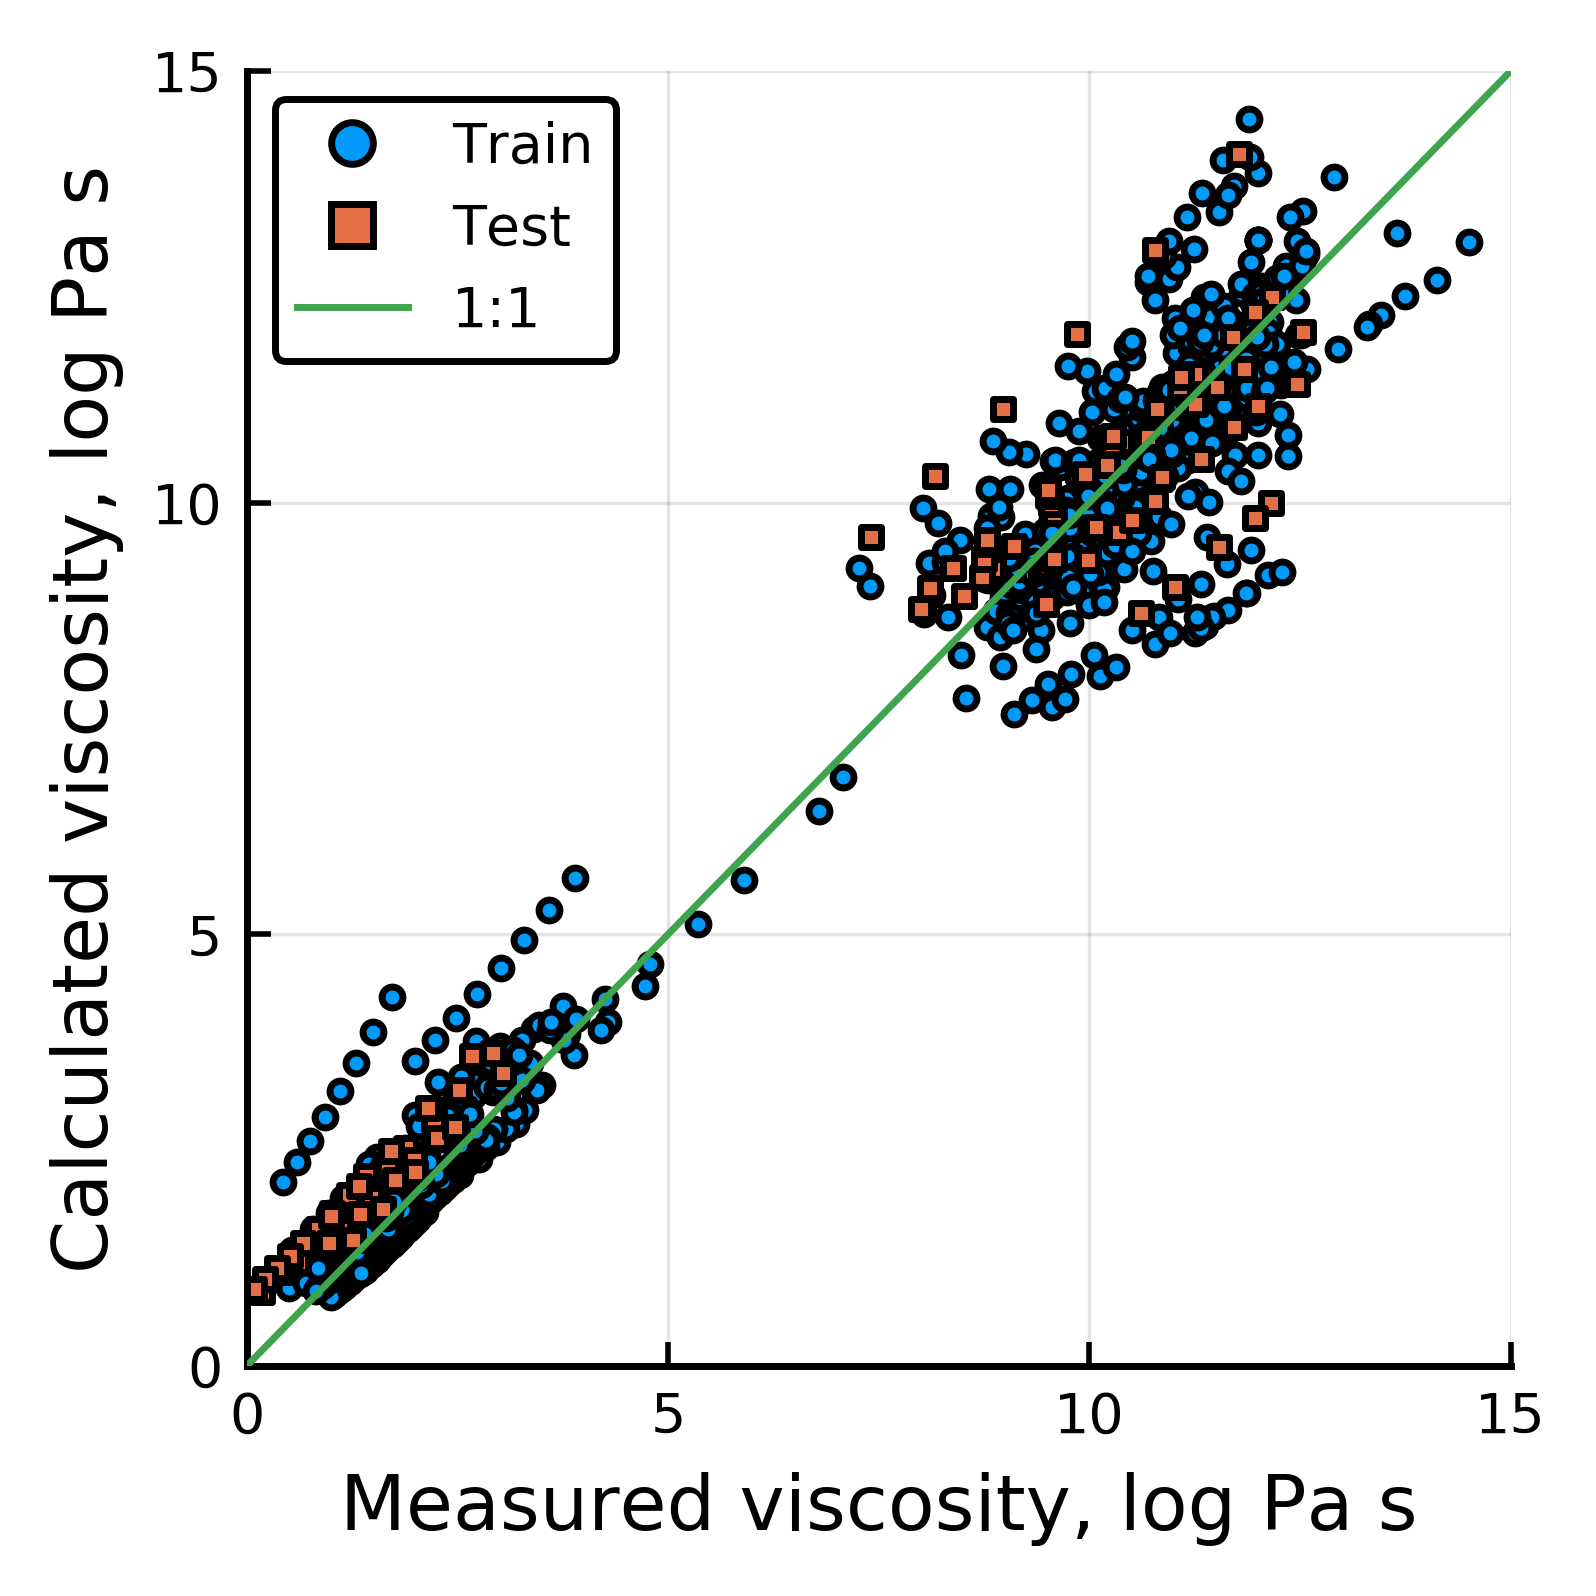

In [47]:
x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid,y_valid)

p1 = scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],
    label="Train",legend=:topleft,m=(3, :auto),
xlabel="Measured viscosity, log Pa s",
ylabel="Calculated viscosity, log Pa s",
xlim=(0,15),
ylim=(0,15),
dpi=500,
size=(300,300))

scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],label="Test",m=(3, :auto))
plot!([0.,16.],[0.,16.],label="1:1")

savefig("./figures/KNAS_visco.png")

In [48]:
print(loss_n(x_train_,T_train_,ap_train_, b_train_,y_train_))
print("\n")
print(loss_n(x_valid_,T_valid_,ap_valid_, b_valid_,y_valid_))

0.8070948315653139 (tracked)
0.899290980926243 (tracked)

# TEST

In [49]:
@load "./model/m1.bson" m1
@load "./model/Ae.bson" Ae
testmode!(m1)

x_test, y_test, T_test, ap_test, b_test, sc_test, tg_test = prepare_datas(X_test,y_test)

scatter(vec(y_test),model(x_test,T_test,ap_test,b_test).data[:])
plot!([0.,16.],[0.,16.])
print(loss_n(x_test,T_test,ap_test,b_test,y_test))


1.167316273687908 (tracked)

In [50]:
mean([1.38,1.42,1.07,1.03,1.43])

1.266

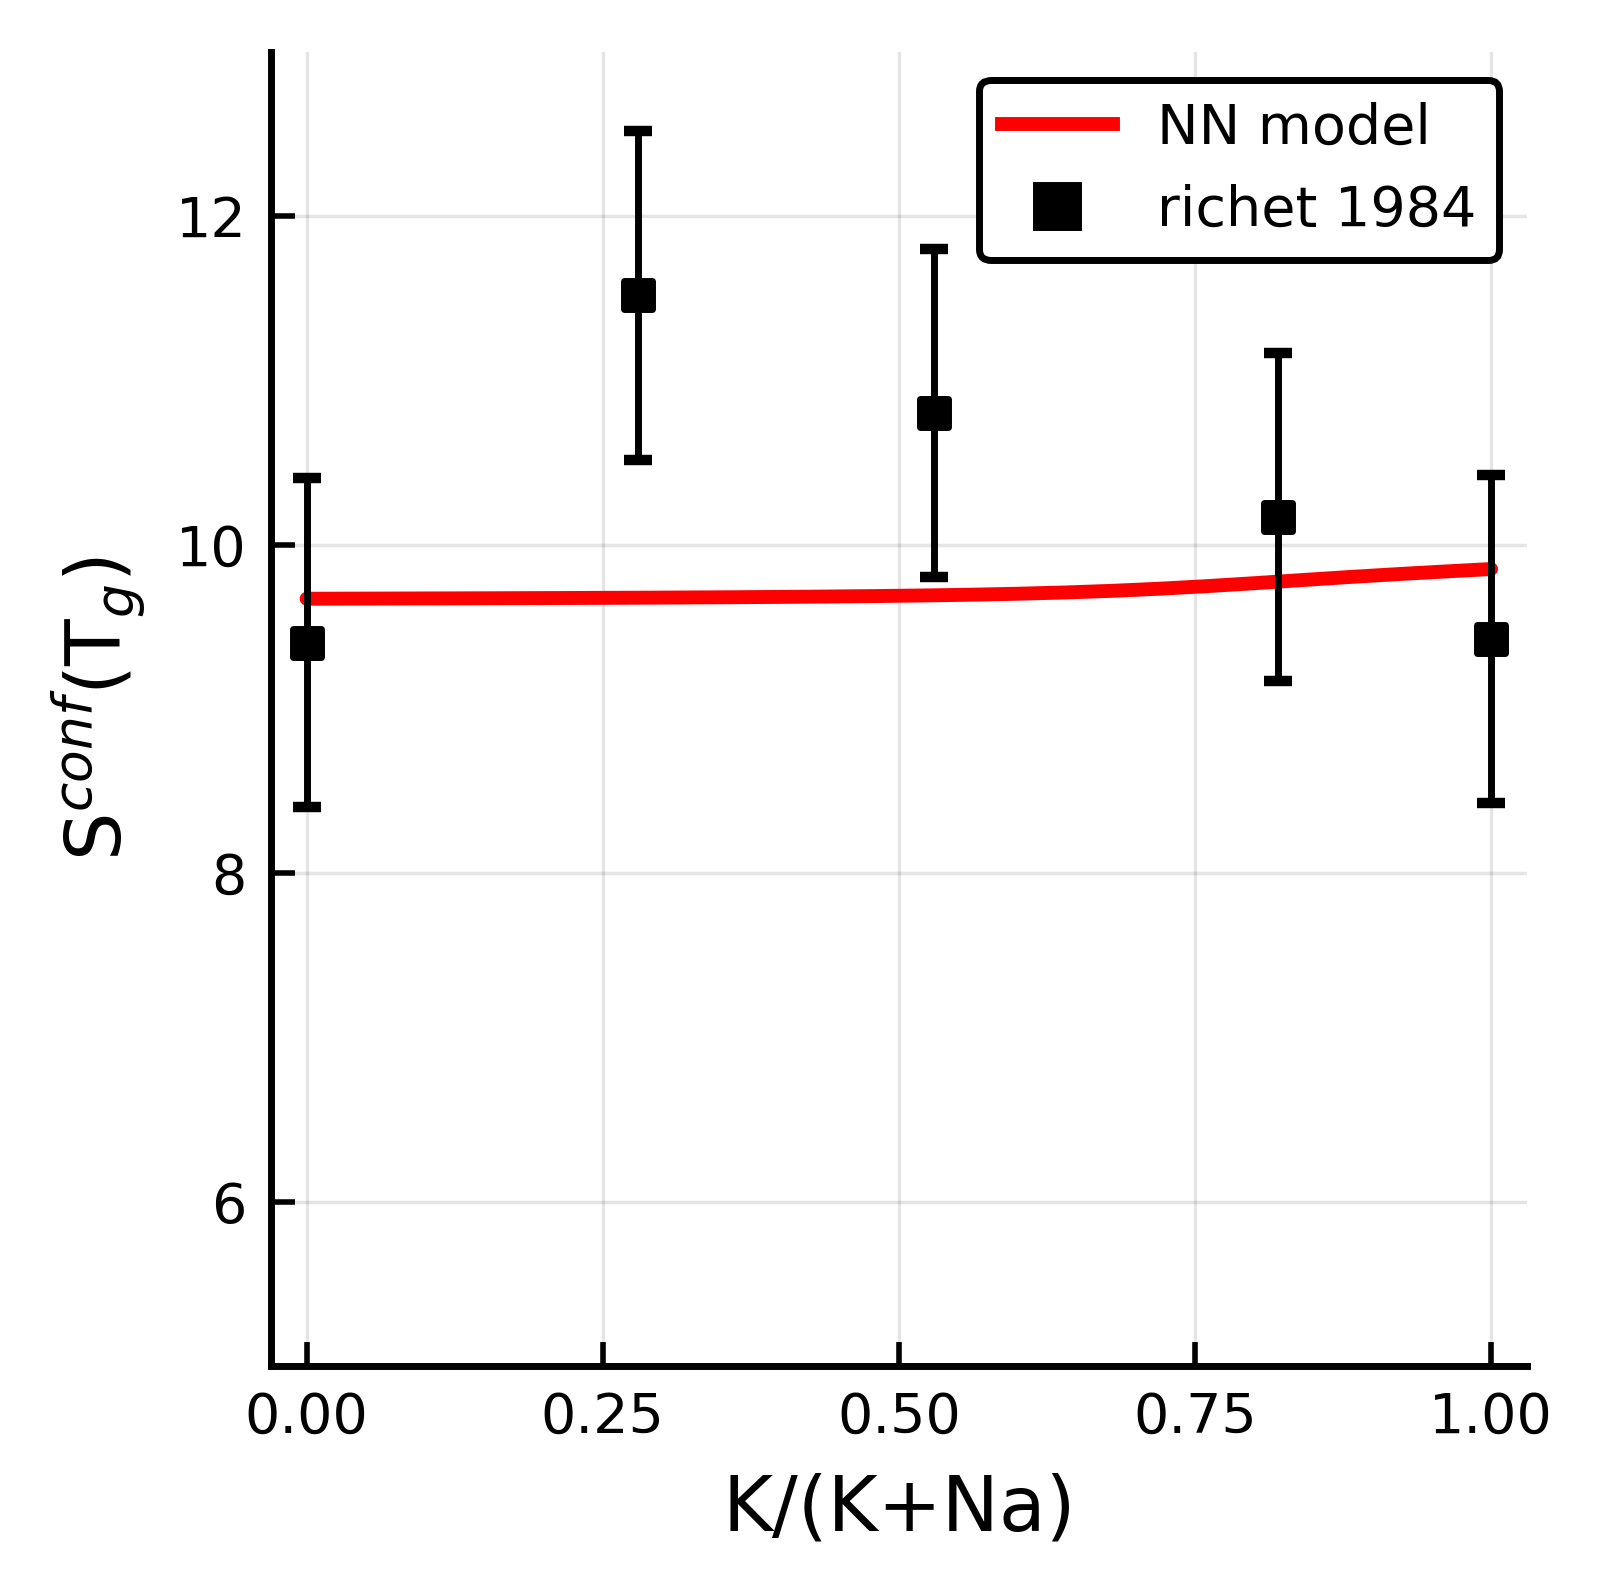

In [51]:
na2o = collect(0.:0.01:0.25)
k2o = 0.25.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = zeros(size(na2o,1))
dummy = zeros(size(na2o,1))
T = ones(size(na2o,1)).*1000.0

X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

# X_visu_NKS_sc = copy(X_visu_NKS)

# for i = 1:7
#     X_visu_NKS_sc[i,:] = (X_visu_NKS_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
# end

plot(X_visu_[4,:]./(X_visu_[3,:].+X_visu_[4,:]),ScTg(X_visu_).data'[:],
    line=("red",2),
    xlabel="K/(K+Na)",
    ylabel=L"S$^{conf}$(T$_g$)",
    ylim=(5,13),
    label="NN model",
    size=(300,300),dpi=500)
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,
    err = 1.0,
    label="richet 1984",
    marker=(:square,"black",4),
    c = :black)

savefig("./figures/KNS_75_Sc.png")

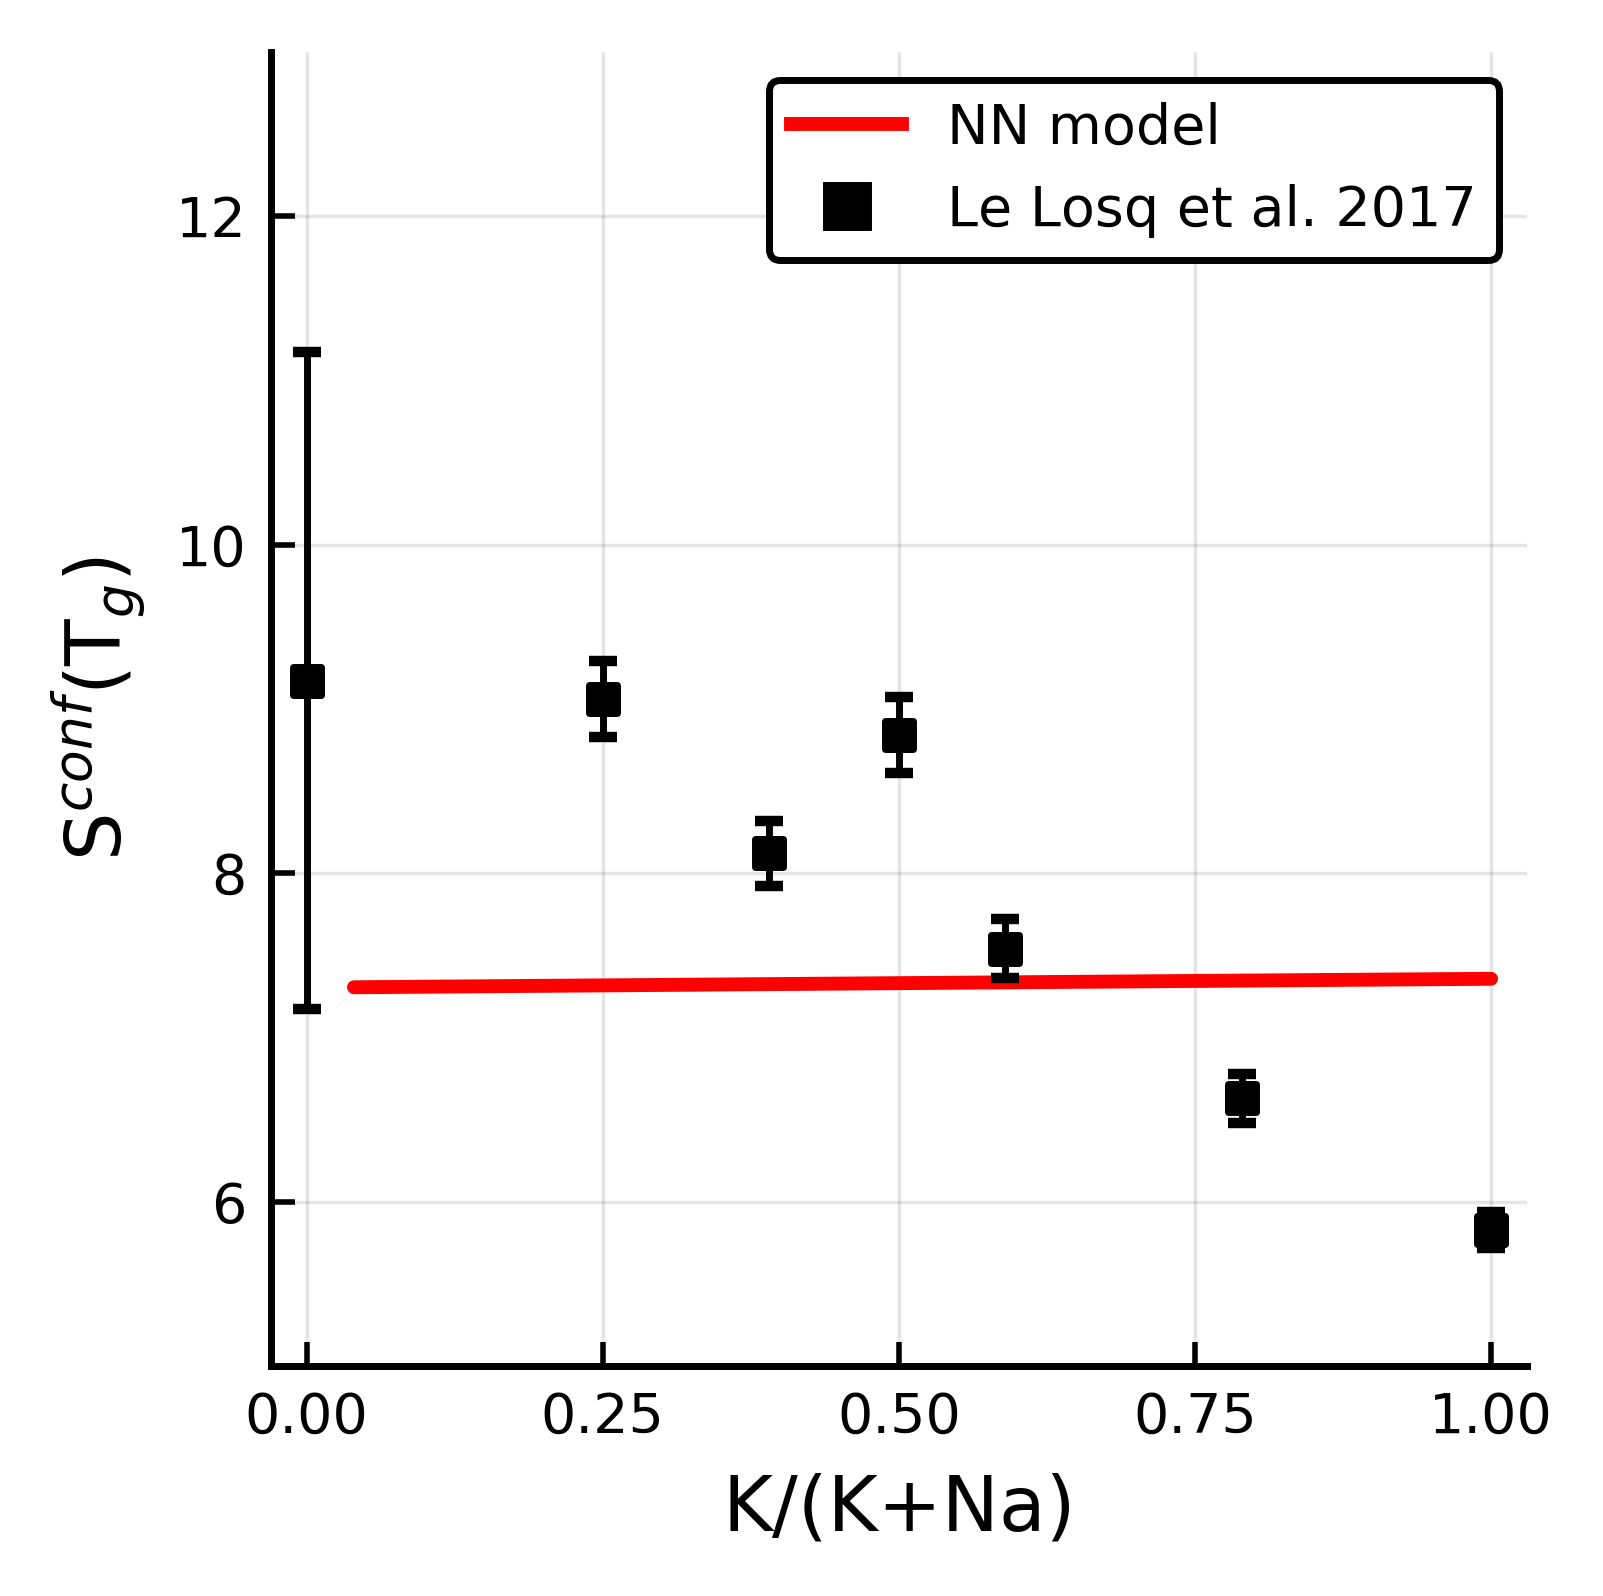

In [42]:
na2o = collect(0.:0.01:0.125)
k2o = 0.125.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = ones(size(na2o,1)).*0.125
dummy = zeros(size(na2o,1))
T = ones(size(na2o,1)).*1000.0

X_visu_ = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

plot(X_visu_[4,:]./(X_visu_[3,:].+X_visu_[4,:]),ScTg(X_visu_).data'[:],
    line=("red",2),
    xlabel="K/(K+Na)",
    ylabel=L"S$^{conf}$(T$_g$)",
    label="NN model",
    ylim=(5,13),
    size=(300,300),dpi=500)
scatter!([0,0.25,0.39,0.50,0.59,0.79,1.00],[9.17,9.06,8.12,8.84,7.54,6.63,5.83],
    err = [2.,0.23,0.20,0.23,0.18,0.15,0.11],
    label="Le Losq et al. 2017",
    marker=(:square,"black",4),
    c = :black)

savefig("./figures/KNAS_75_Sc.png")

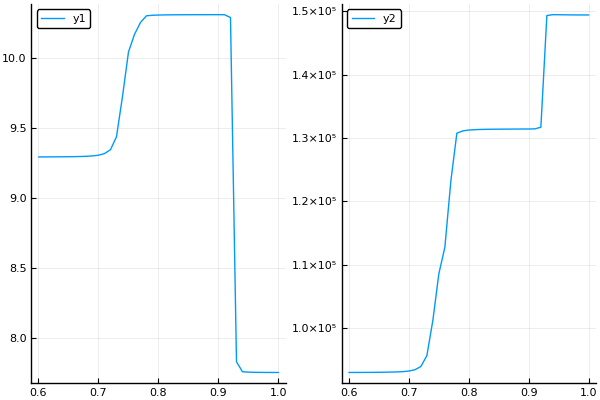

In [43]:
sio2 = collect(0.6:0.01:1.)
al2o3 = zeros(size(sio2,1))
na2o = 1.0.-sio2
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_NS = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

X_visu_NS_sc = copy(X_visu_NS)

for i = 1:7
    X_visu_NS_sc[i,:] = (X_visu_NS_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

plot([X_visu_NS[1,:],X_visu_NS[1,:]],
    [ScTg(X_visu_NS_sc).data'[:],Be(X_visu_NS_sc).data'[:]],
layout=2)


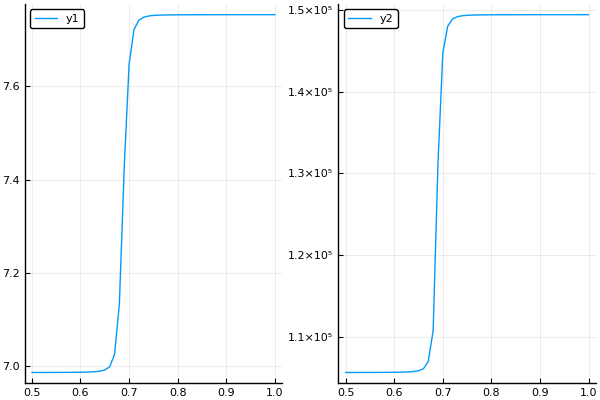

In [44]:
sio2 = collect(0.5:0.01:1.)
al2o3 = (1.0.-sio2)./2.0
k2o = copy(al2o3)
na2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

X_visu_sc = copy(X_visu)

for i = 1:7
    X_visu_sc[i,:] = (X_visu_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
end

plot([X_visu[1,:],X_visu[1,:]],
    [ScTg(X_visu_sc).data'[:],Be(X_visu_sc).data'[:]],
layout=2)


In [18]:
plot(predictions_train.data[:],y.parent[:],"ks",alpha=0.1)
plot([0,15],[0,15],"k--")
plot([0,15.0],[0,15.].-0.5,"b--")
plot([0,15.],[0,15.].+0.5,"b--")

UndefVarError: UndefVarError: predictions_train not defined

In [195]:
plot([0,12]-0.5,[0,12]-0.5,"k--")

MethodError: MethodError: no method matching -(::Array{Int64,1}, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:397
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:298
  -(!Matched::Missing, ::Number) at missing.jl:97
  ...

In [188]:
predictions_train.data[:]

620-element Array{Float64,1}:
  2.3032444067117757
  2.623692405633248 
  3.027915455938361 
  3.4222450165673743
  3.8926449255113944
  4.370103390672524 
  4.8876503648035   
  5.469334558026265 
  6.356743420865268 
  6.78613859050153  
  8.327278676684431 
  9.051372238986819 
  9.944407111041677 
  ⋮                 
  1.4055438658956634
  1.4422492073169009
  1.479413679478652 
  1.5170459511904548
  1.5551549108774632
  1.5937496735794525
  1.6328395882192055
  1.6724342451524592
  9.332781439644776 
 10.09932163190039  
 10.621319672155154 
 11.212695098263817 

In [191]:
m1(x)

Tracked 1×620 Array{Float32,2}:
 15123.9  15123.9  15123.9  15123.9  …  8035.39  8035.39  8035.39  8035.39